In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer, seed_everything
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import skipgrammar.datasets as dset
from skipgrammar.models.lightning import SGNS

In [4]:
seed_everything(7);

Global seed set to 7


## Data

In [5]:
%%time

variant = 'lastfm-50'

lastfm_dataset = dset.LastFMUserItemDataset(
    variant=variant,
    min_item_cnt_thresh=5, min_user_item_cnt_thresh=5,
    subsample_thresh=1e-3, item_dist_exp=-0.5,
    session_timedelta='800s',
    max_window_size_lr=12, max_sequence_length=25,
    shuffle=True,
)

16384/8676 [========================================================] - 0s 0us/step
CPU times: user 1.3 s, sys: 305 ms, total: 1.61 s
Wall time: 7.51 s


In [6]:
lastfm_dataset.df.shape

(647101, 9)

In [7]:
lastfm_dataset.df.sample(3)

,user_id,timestamp,artist_id,artist_name,track_id,track_name,artist_cd,session_end,session_nbr
506511,user_000507,2009-01-16 17:02:38+00:00,2449300a-6ca7-45da-8102-22789d256475,Kamelot,bdb822db-0f4c-46ce-a507-0c33af4cf6a5,Temples Of Gold,3929,0,2044
559188,user_000647,2006-05-23 15:20:18+00:00,c296e10c-110a-4103-9e77-47bfebb7fb2e,Bob Marley & The Wailers,13ef609a-ceb6-44c5-b1cd-6ed05b8948cf,Could You Be Loved,985,0,518
518608,user_000607,2006-04-30 13:40:45+00:00,b863cf80-19c6-4a87-8e42-6cff7ac8f18f,Immortal,9cf8ba9e-4da4-4d0f-ae40-fb0eed526199,In My Kingdom Cold,3434,0,3


In [8]:
lastfm_dataset.df.groupby('user_id').size().describe()

count       50.000000
mean     12942.020000
std      13896.548897
min          9.000000
25%       2897.000000
50%       9164.000000
75%      17371.750000
max      67223.000000
dtype: float64

In [9]:
lastfm_dataset.df.groupby('artist_cd').size().describe()

count    8937.000000
mean       72.406960
std       205.794933
min         5.000000
25%         8.000000
50%        17.000000
75%        53.000000
max      7181.000000
dtype: float64

In [10]:
lastfm_dataset.df.groupby(['user_id', 'session_nbr']).size().reset_index(level=1).describe().rename(columns={0: 'session_listens'})

,session_nbr,session_listens
count,59853.000000,59853.000000
mean,1333.361051,10.811505
std,1297.986240,18.512058
min,1.000000,1.000000
25%,373.000000,2.000000
50%,939.000000,6.000000
75%,1795.000000,13.000000
max,6427.000000,789.000000


In [11]:
lastfm_dataset.df.groupby(['user_id', 'session_nbr']).size().reset_index(level=1).quantile([
    0.16, 0.25, 0.50, 0.75, 0.84, 0.90, 0.98, 0.99
]).rename(columns={0: 'session_listens'}).T

,0.16,0.25,0.50,0.75,0.84,0.90,0.98,0.99
session_nbr,221.0,373.0,939.0,1795.0,2547.68,3266.0,5229.96,5828.48
session_listens,1.0,2.0,6.0,13.0,18.00,25.0,56.00,77.00


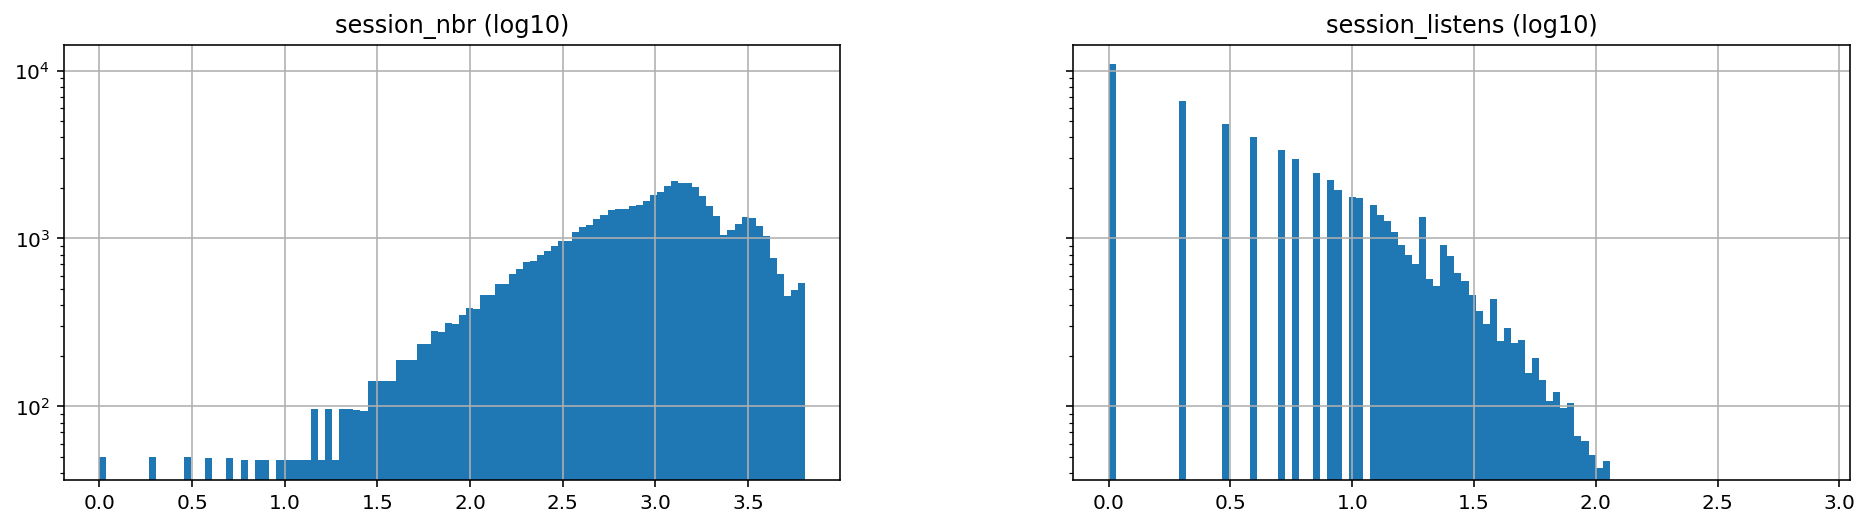

In [12]:
axes = lastfm_dataset.df.groupby(['user_id', 'session_nbr']).size().reset_index(level=1)\
    .rename(columns={0: 'session_listens'})\
    .transform('log10')\
    .rename(columns={'session_listens': 'session_listens (log10)', 'session_nbr': 'session_nbr (log10)'})\
    .hist(bins=100, figsize=(16, 4), sharex=False, sharey=True)[0].tolist()
axes[0].set_yscale('log');
axes[1].set_yscale('log');

In [13]:
lastfm_dataloader = DataLoader(lastfm_dataset, batch_size=32, num_workers=6, drop_last=True)

In [14]:
model = SGNS(
    num_embeddings=lastfm_dataset.num_items, embedding_dim=128,
    weights=lastfm_dataset.item_dist, num_negative_samples=20, nn_embedding_kwargs={'sparse': True},
    learning_rate=0.003
)

## Training

In [15]:
tb_logger = pl_loggers.TensorBoardLogger('logs/', name=f'sgns-{variant}')

### Dry Run

In [16]:
trainer = Trainer(logger=tb_logger, fast_dev_run=True)

/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [18]:
trainer.fit(model, train_dataloaders=lastfm_dataloader)


  | Name              | Type      | Params
------------------------------------------------
0 | embeddings        | Embedding | 1.1 M 
1 | target_embeddings | Embedding | 1.1 M 
------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.151     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

### Train

In [19]:
trainer = Trainer(logger=tb_logger, max_epochs=5, progress_bar_refresh_rate=100)

/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model, train_dataloaders=lastfm_dataloader)

Missing logger folder: logs/sgns-lastfm-50

  | Name              | Type      | Params
------------------------------------------------
0 | embeddings        | Embedding | 1.1 M 
1 | target_embeddings | Embedding | 1.1 M 
------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.151     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [21]:
lu = lastfm_dataset.id_metadata
len(lu)

8937

In [22]:
embeddings = model.embeddings.weight.detach().cpu().numpy()
embeddings.shape

(8937, 128)

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [24]:
num_embeddings = 4000
rand_embedding_ids = np.random.randint(0, len(embeddings), num_embeddings)
tsne = TSNE()
embeddings_reduced = tsne.fit_transform(embeddings[rand_embedding_ids, :])
embeddings_reduced.shape

(4000, 2)

/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12459 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12524 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/seqrep/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 19978 missing from c

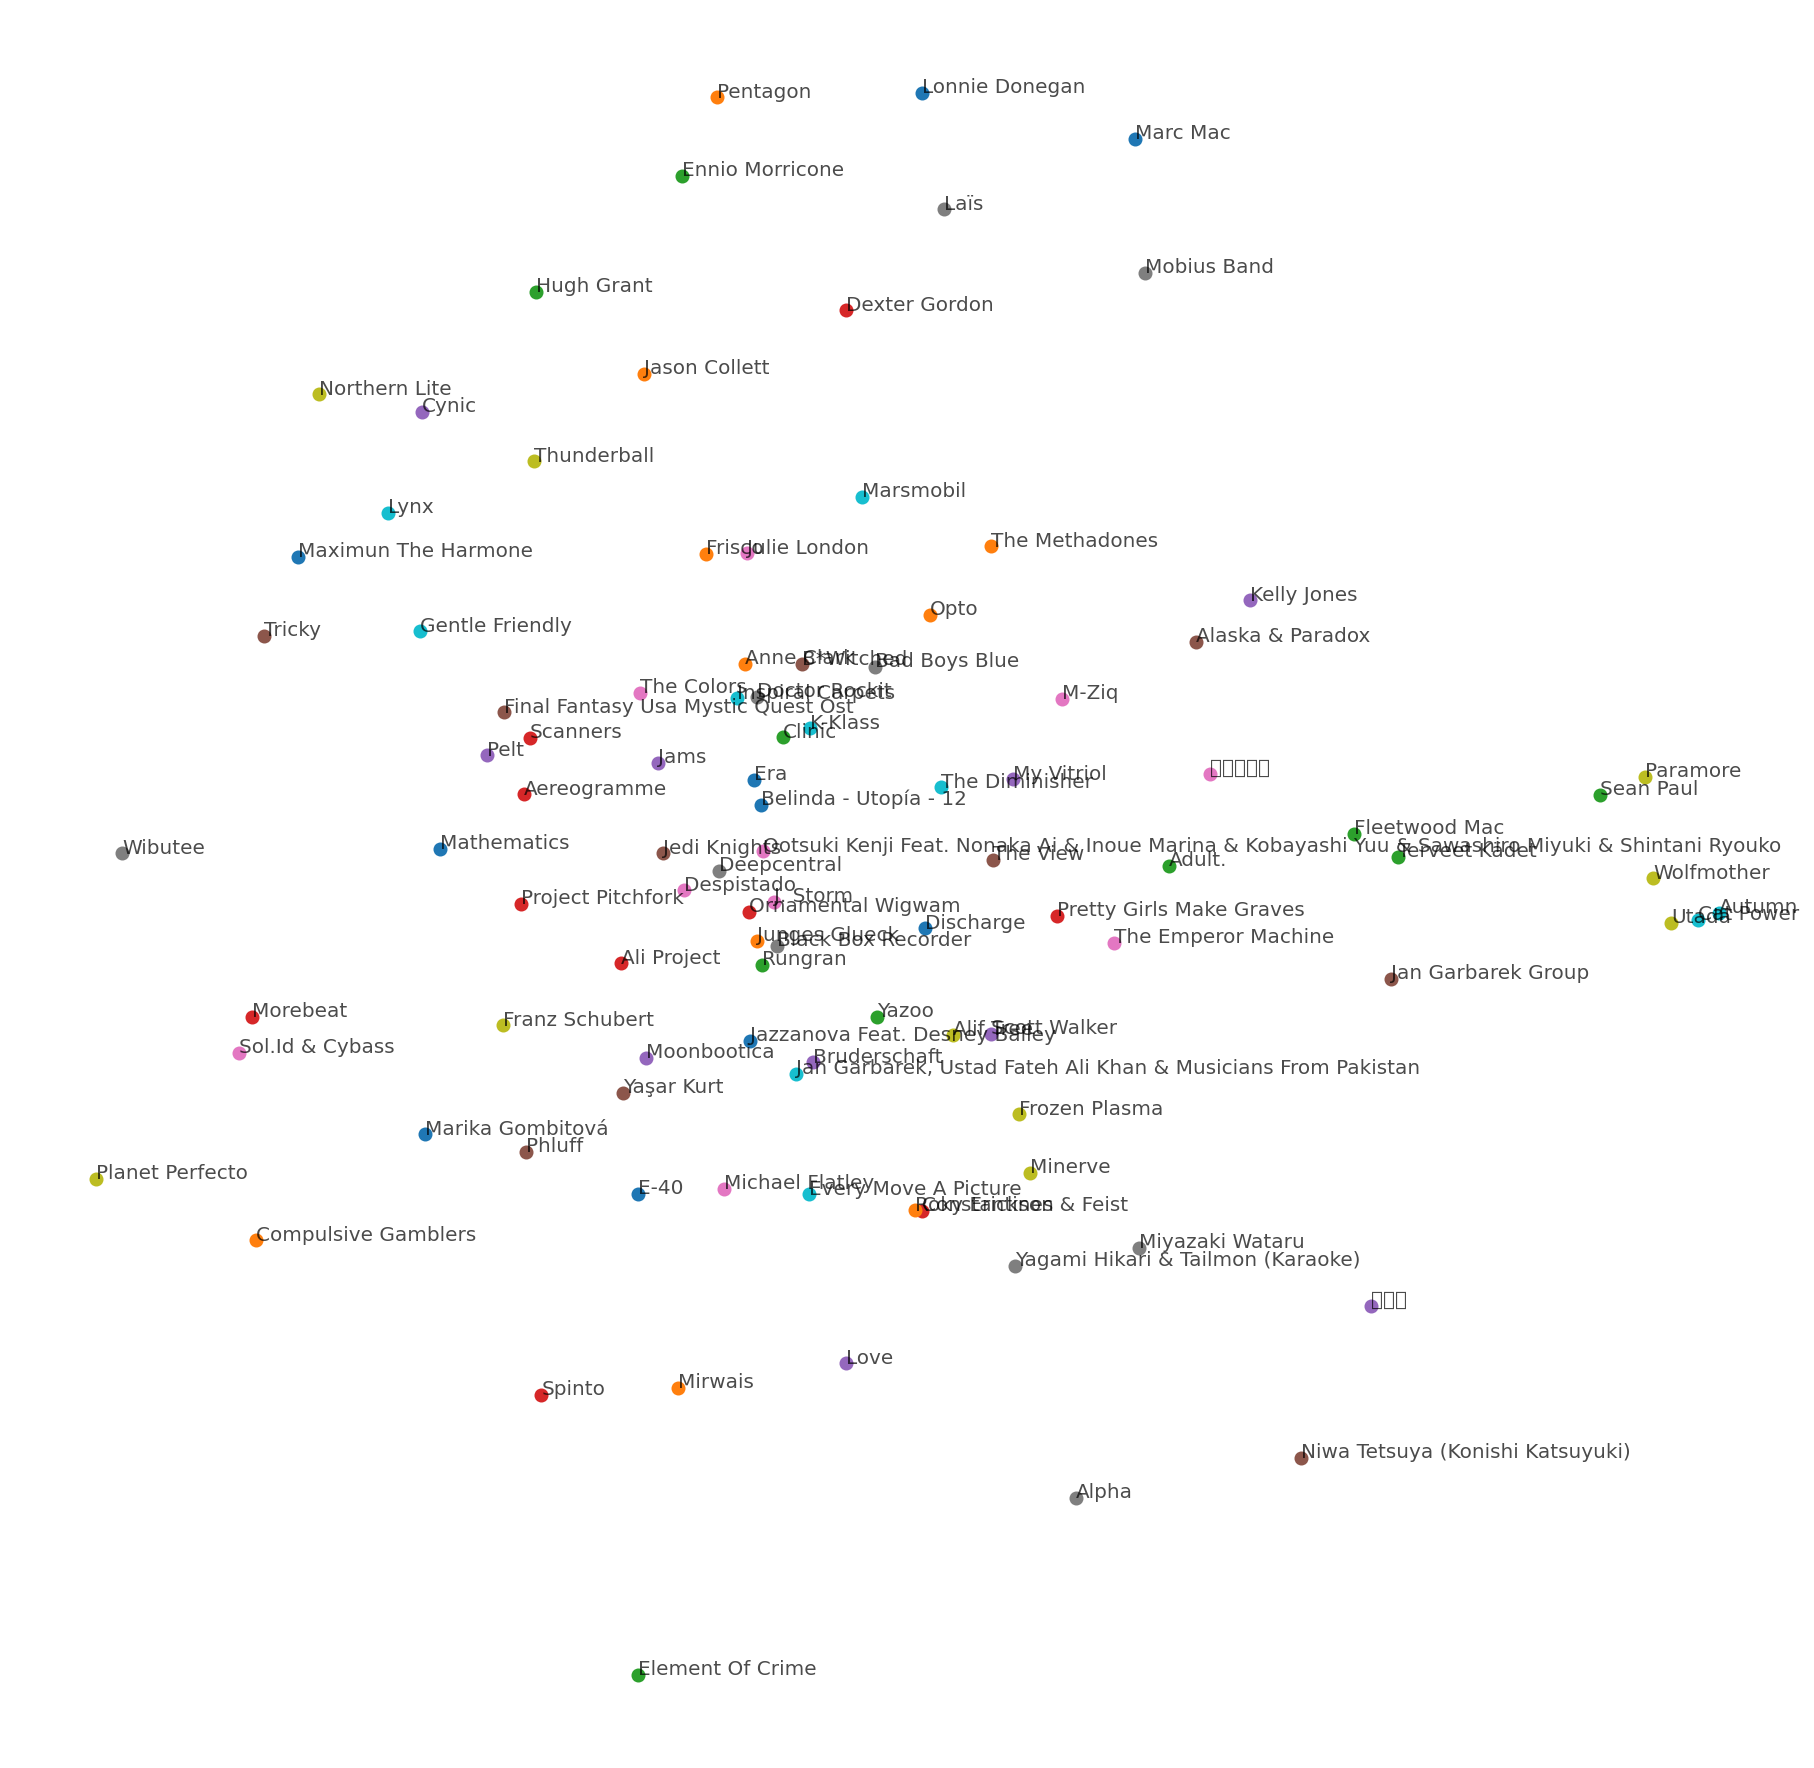

In [25]:
fig, ax = plt.subplots(figsize=(16, 16))
for i, embedding_id in enumerate(rand_embedding_ids):
    if (i+1) % 40 == 0:
        try:
            plt.scatter(embeddings_reduced[i, 0], embeddings_reduced[i, 1])
            plt.annotate(lu[embedding_id], (embeddings_reduced[i, 0], embeddings_reduced[i, 1]), alpha=0.7)
        except:
            pass
plt.axis('off');